<a href="https://colab.research.google.com/github/frasercrichton/fastai2-learning/blob/master/nbs/TripleChaserFastAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
bs = 64     # default batch size
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install fastai2 -q
!pip install utils
from utils import *
from fastai2.vision.all import *


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  19787      0 --:--:-- --:--:-- --:--:-- 19787
OK
62 packages can be upgraded. Run 'apt list --upgradable' to see them.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 184kB 2.7MB/s 


In [2]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)


<IPython.core.display.Javascript object>

Authenticate against GCP related

In [3]:
from google.colab import auth
auth.authenticate_user()

In [5]:
!rm -rf "data" 
!mkdir "data"
!rm -rf "download" 
!mkdir "download"
project_id = "forensic-265906"
!gcloud config set project {project_id}
!gsutil -m cp -r gs://forensic-architecture-machine-learning/canisters/canisters.zip download/canisters.zip


Updated property [core/project].
Copying gs://forensic-architecture-machine-learning/canisters/canisters.zip...
| [1/1 files][276.4 MiB/276.4 MiB] 100% Done                                    
Operation completed over 1 objects/276.4 MiB.                                    


In [7]:
%%capture
!rm -rf "data" 
!unzip "download/canisters.zip" 

## Examine the contents of the bucket

Lets get the bucket and have a look at how it's annotated . . .

In [ ]:
!ls data/canisters/real_val/

ann  img


In [8]:

path = Path('data/canisters/real_val/'); path

Path('data/canisters/real_val')

Now lets see some of those images

In [9]:
annotations_path = path/'ann'
images_path = path /'img'
 #augmentations = augmentations

fnames = get_image_files(images_path)
fnames

(#265) [Path('data/canisters/real_val/img/zbatch2__19nov2011tahrir8.png'),Path('data/canisters/real_val/img/zbatch2__Yugoimport stock image CS triple.png'),Path('data/canisters/real_val/img/1550493971258.png'),Path('data/canisters/real_val/img/zbatch2__19nov2011tahrir2.png'),Path('data/canisters/real_val/img/IMG_0300.jpeg'),Path('data/canisters/real_val/img/B3Qn-6OCEAAF3RU.jpeg'),Path('data/canisters/real_val/img/1920px-CS_gas_shells,_Taksim_Gezi_Park,_Istanbul,_31-05-2013.jpeg'),Path('data/canisters/real_val/img/1550226400476.png'),Path('data/canisters/real_val/img/1549902899272.png'),Path('data/canisters/real_val/img/20190220__1549534886442.jpeg')...]

Work towards adding this into a 'utility' class

In [18]:
# no idea what to call this at the moment but this will do for now
class BasicDataHolder():
 def __init__(self,
        path: Union[str, Path]):
   print("stuff",  path.absolute)
   

BasicDataHolder(path)


stuff <bound method Path.absolute of Path('data/canisters/real_val')>


In [10]:
images = list(
  sorted(
    filter(
      lambda _pth: _pth.suffix.lstrip(".").lower()
      in {"jpeg", "jpg", "png"},
      images_path.iterdir(),
    )
  )
)
images[0]

Path('data/canisters/real_val/img/1000w_q95.jpeg')

In [11]:
annotationsDict = { 
  image_file.name : 
  annotations_path / f"{image_file.name}.json"           
  for image_file in images
}
annotationsDict['1000w_q95.jpeg']

Path('data/canisters/real_val/ann/1000w_q95.jpeg.json')

In [12]:
def label_func(imagePath):
  image_name = imagePath.name
  file = annotationsDict[image_name]
  annotation_data = json.loads(file.read_text())
  if annotation_data["objects"]:
    return annotation_data["objects"][0]["classTitle"]
  else: 
    return "label"
label_func(Path('1550508269245.png'))


'canister-general-bbox'

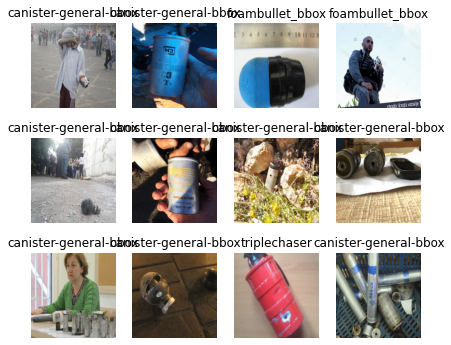

In [13]:
dls = ImageDataLoaders.from_path_func(images_path, fnames, label_func,
                                      item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=bs//2,
                                     batch_tfms=[*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)])
# , item_tfms=Resize(460), bs=bs, batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
dls.show_batch(max_n=12, figsize=(7,6))

In [14]:
print(dls.vocab)
len(dls.vocab),dls.c

(#8) ['canister-general-bbox','foambullet_bbox','label','triple-bottom','triple-top','triple_bottom_bitmap','triple_chaser_bitmap','triplechaser']


(8, 8)

In [15]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fit_one_cycle(10)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,3.222822,2.483404,0.905660,00:24
1,3.102532,2.091719,0.641509,00:18
2,2.524595,1.686191,0.415094,00:17
3,2.062691,1.997374,0.358491,00:17
4,1.715818,1.940963,0.396226,00:18
5,1.425305,1.895463,0.396226,00:17
6,1.215856,1.833741,0.339623,00:18
7,1.043147,1.777908,0.320755,00:17
8,0.918453,1.769915,0.301887,00:18
9,0.813416,1.747720,0.320755,00:17


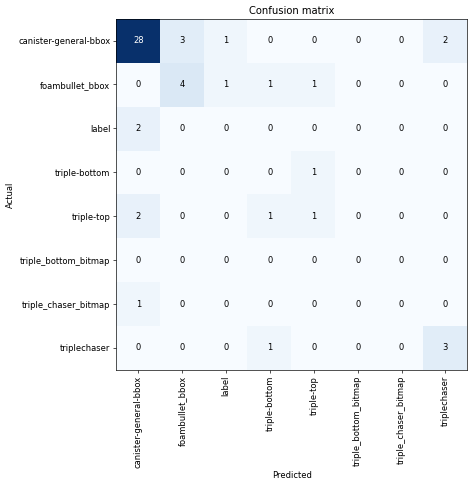

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)